In [2]:
#from mpl_toolkits import mplot3d
import pandas as pd
from numpy import array
import numpy as np
import h5py
import mplcursors
import matplotlib.pyplot as plt
from scipy.stats import pearsonr
%matplotlib inline
plt.rcParams.update({
    "pgf.texsystem": "pdflatex",
    "pgf.rcfonts": False,

    "text.usetex": True,
    "font.family": "serif",
    "font.sans-serif": "computer-modern-roman",

    "figure.dpi": 300,
    "savefig.dpi": 300,
})


CMAPS = plt.colormaps
CMAP = CMAPS['hsv']

h = 0.6774  # co-moving constant


In [3]:


dat = h5py.File('global_sample_data_snapshot_1200.hdf5')

# for x in dat.values():
#     try:
#         list(x)
#     except:
#         print(x)
#         raise
dat = pd.DataFrame((list(x) for x in dat.values() if x.shape != ()), index=(
    k for k in dat.keys() if dat[k].shape != ())).transpose()


In [4]:
import matplotlib as mpl


dat['is_satellite'] = dat['groupID'] != -1

dat.loc[dat['is_satellite'] == False, 'plot_shape'] = 'o'
dat.loc[dat['is_satellite'], 'plot_shape'] = '^'

for mu in 'X', 'Y', 'Z':
    dat[f'{mu}_Mpc_ahf_cat'] = dat[f'{mu}c_ahf_cat'] / h

s_filt = dat['groupID'] != -1
h_filt = dat['groupID'] == -1


# M_tot calculation
dat['M_tot'] = (
    dat['stars_mass_within_r50_stars'] + 
    dat['gas_mass_within_r50_stars'] + 
    dat['dm_mass_within_r50_stars']
)

dat['M_*/M_tot'] = _c = dat['stars_mass_within_r50_stars'] / dat['M_tot']

m_dm_frac_norm = mpl.colors.LogNorm(np.min(_c), np.max(_c))

In [5]:
# # OLD

# filt = dat['stars_mass_within_r50_stars'] < 1e9

# m, b = np.polyfit(
#     dat[filt]['stars_mass_within_r50_stars_ahf'],
#     dat[filt]['r50_stars_ahf'],
#     deg=1
# )

# # polynomial
# x = np.linspace(1e6, 1e9, 100)
# y = m*x+b

# lin_fit = (x, y)


In [6]:
filt = dat['stars_mass_within_r50_stars'] < 1e9

m, b = np.polyfit(
    np.log(dat[filt]['stars_mass_within_r50_stars_ahf']),
    np.log(dat[filt]['r50_stars_ahf'] / h),
    deg=1,
)

x = np.linspace(13, 25, dat[filt].shape[0],
                dtype=np.float64)

y = m*x + b

pwr_fit = x, y

dat['beta_r50'] = (
    np.log(dat['r50_stars_ahf'] / h)
    - (m * np.log(dat['stars_mass_within_r50_stars_ahf']) + b)
)

(
    np.mean(dat[filt]['beta_r50']),
    np.std(dat[filt]['beta_r50']),
    m,
    b
)

c:\Users\MkZee\anaconda3\envs\thesis\lib\site-packages\pandas\core\arraylike.py:397: RuntimeWarning: divide by zero encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)


(-6.173289990394284e-16,
 0.27575817229976585,
 0.14713403411266374,
 -0.8970539921812536)

In [7]:
# def sates(arr):
#     return np.fromiter((n for i, n in enumerate(arr) if dat['groupID'][i] != -1), dtype=float)


# def hosts(arr):
#     return np.fromiter((n for i, n in enumerate(arr) if dat['groupID'][i] == -1), dtype=float)

# def norm(arr: np.ndarray) -> np.ndarray:
#     return arr / arr.max()


# m_dict = {
#     'Hosts': (dat[dat['is_satellite'] == False]),
#     'Satellites': (dat[dat['is_satellite'] == True])
# }


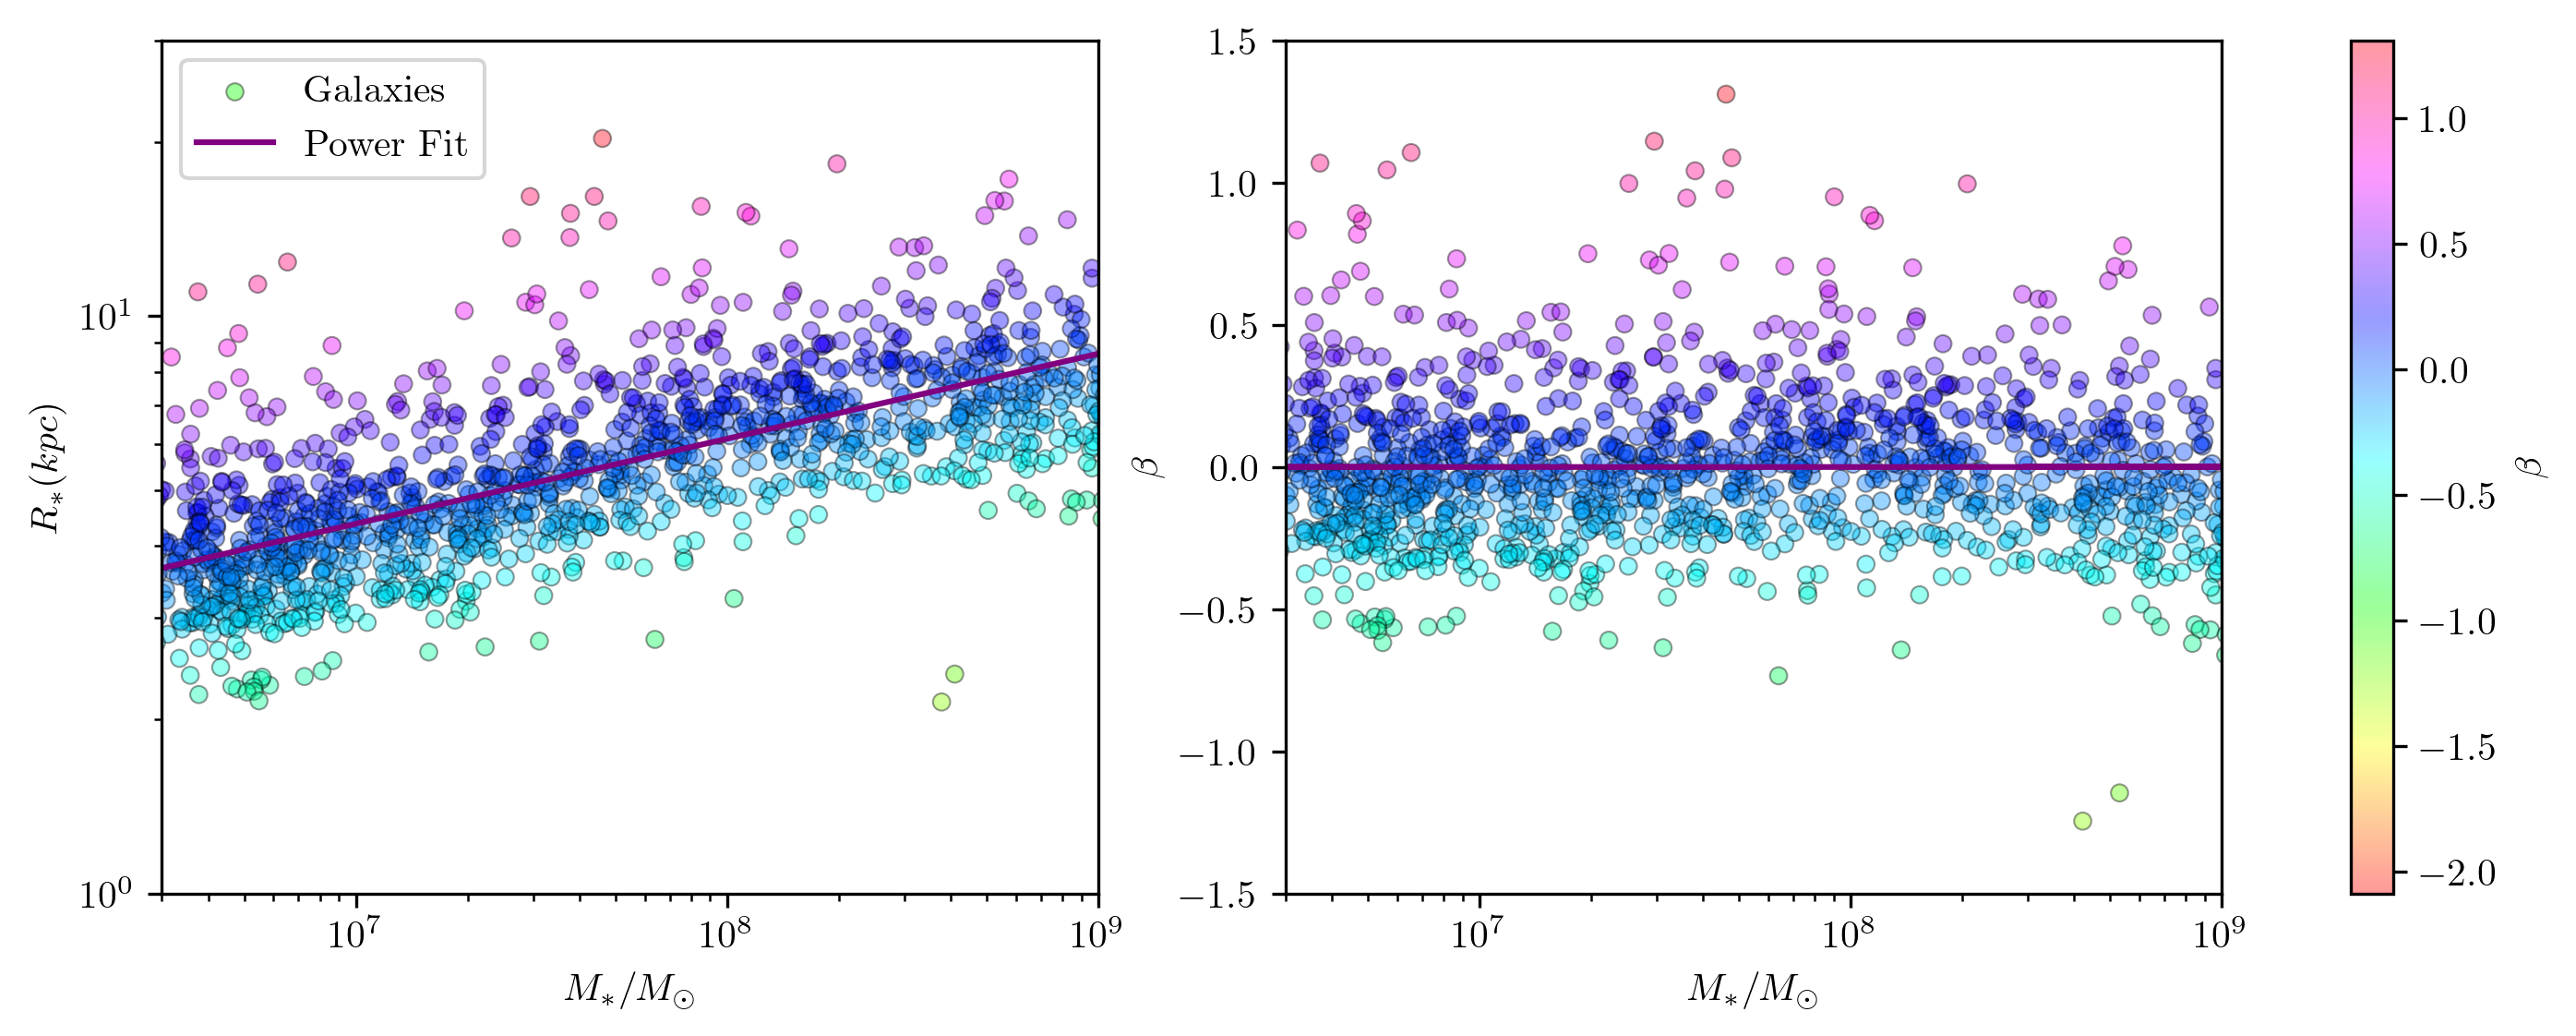

In [8]:

fig, (ax, ax2) = plt.subplots(1, 2)

fig.set_figwidth(12)
fig.set_figheight(4)

ax.set_xscale('log')
ax.set_yscale('log')

d = dat
mask = d['beta_r50'] > -np.inf  # no mask
x, y = d[mask]['stars_mass_within_r50_stars_ahf'], d[mask]['r50_stars_ahf'] / h

_m = ax.scatter(x, y, alpha=0.4, s=20, marker='o',
                cmap=CMAPS['hsv'], c=d[mask]['beta_r50'], edgecolor='black', linewidth=0.5,
                )

ax.plot(np.exp(pwr_fit[0]), np.exp(pwr_fit[1]), color='purple')
ax.set_xlim(3e6, 1e9)
ax.set_ylim(1e0, 3e1)
ax.legend(('Galaxies', 'Power Fit'))
ax.set_xlabel(r'$M_{*} / M_\odot$')
ax.set_ylabel(r'$R_{*} (kpc)$')


ax2.set_xscale('log')
ax2.set_xlim(3e6, 1e9)
ax2.set_ylim(-1.5, 1.5)
ax2.set_xlabel(r'$M_* / M_\odot$')
ax2.set_ylabel(r'$\beta$')

ax2.scatter(
    dat['stars_mass_within_r50_stars'],
    dat['beta_r50'],
    s=20,
    marker='o',
    c=dat['beta_r50'],
    edgecolor='black',
    linewidth=0.5,
    alpha=0.4,
    cmap=CMAP
)

ax2.plot(dat['stars_mass_within_r50_stars'], [0] * dat.shape[0], color='purple')


fig.colorbar(_m, ax=[ax, ax2]).set_label(r'$\beta$')


fig.savefig('paper/figs/me/stars-mass-size-r50.pdf')




In [9]:
dat.to_pickle('beta_data.pickle')

# Proximity to host galaxy


In [10]:

dat['prox_to_host'] = np.nan


prox_to_host = np.zeros(dat.shape[0])
host_rvir_cat = np.zeros(dat.shape[0])

for i in range(len(prox_to_host)):
    host_info = dat[dat['groupID'][i] == dat['galaxyID']]
    host_i = host_info.first_valid_index()
    self_info = dat.iloc[i]

    if self_info.empty or host_info.empty:
        prox_to_host[i] = np.nan
        continue

    for j in ('X_Mpc_ahf_cat', 'Y_Mpc_ahf_cat', 'Z_Mpc_ahf_cat'):
        diff = abs(host_info[j][host_i] - dat[j][i])  # coordinate delta
        # to account for the coordinate wrap-around (the universe repeats!)
        diff = diff if diff < 7500/h else 15000/h - diff
        prox_to_host[i] += (diff)**2

    prox_to_host[i] = np.sqrt(prox_to_host[i])
    
    
    # R_vir
    host_rvir_cat[i] = host_info['Rvir_ahf_cat'][host_i]
    


dat['prox_to_host'] = prox_to_host
dat['host_rvir_cat'] = host_rvir_cat




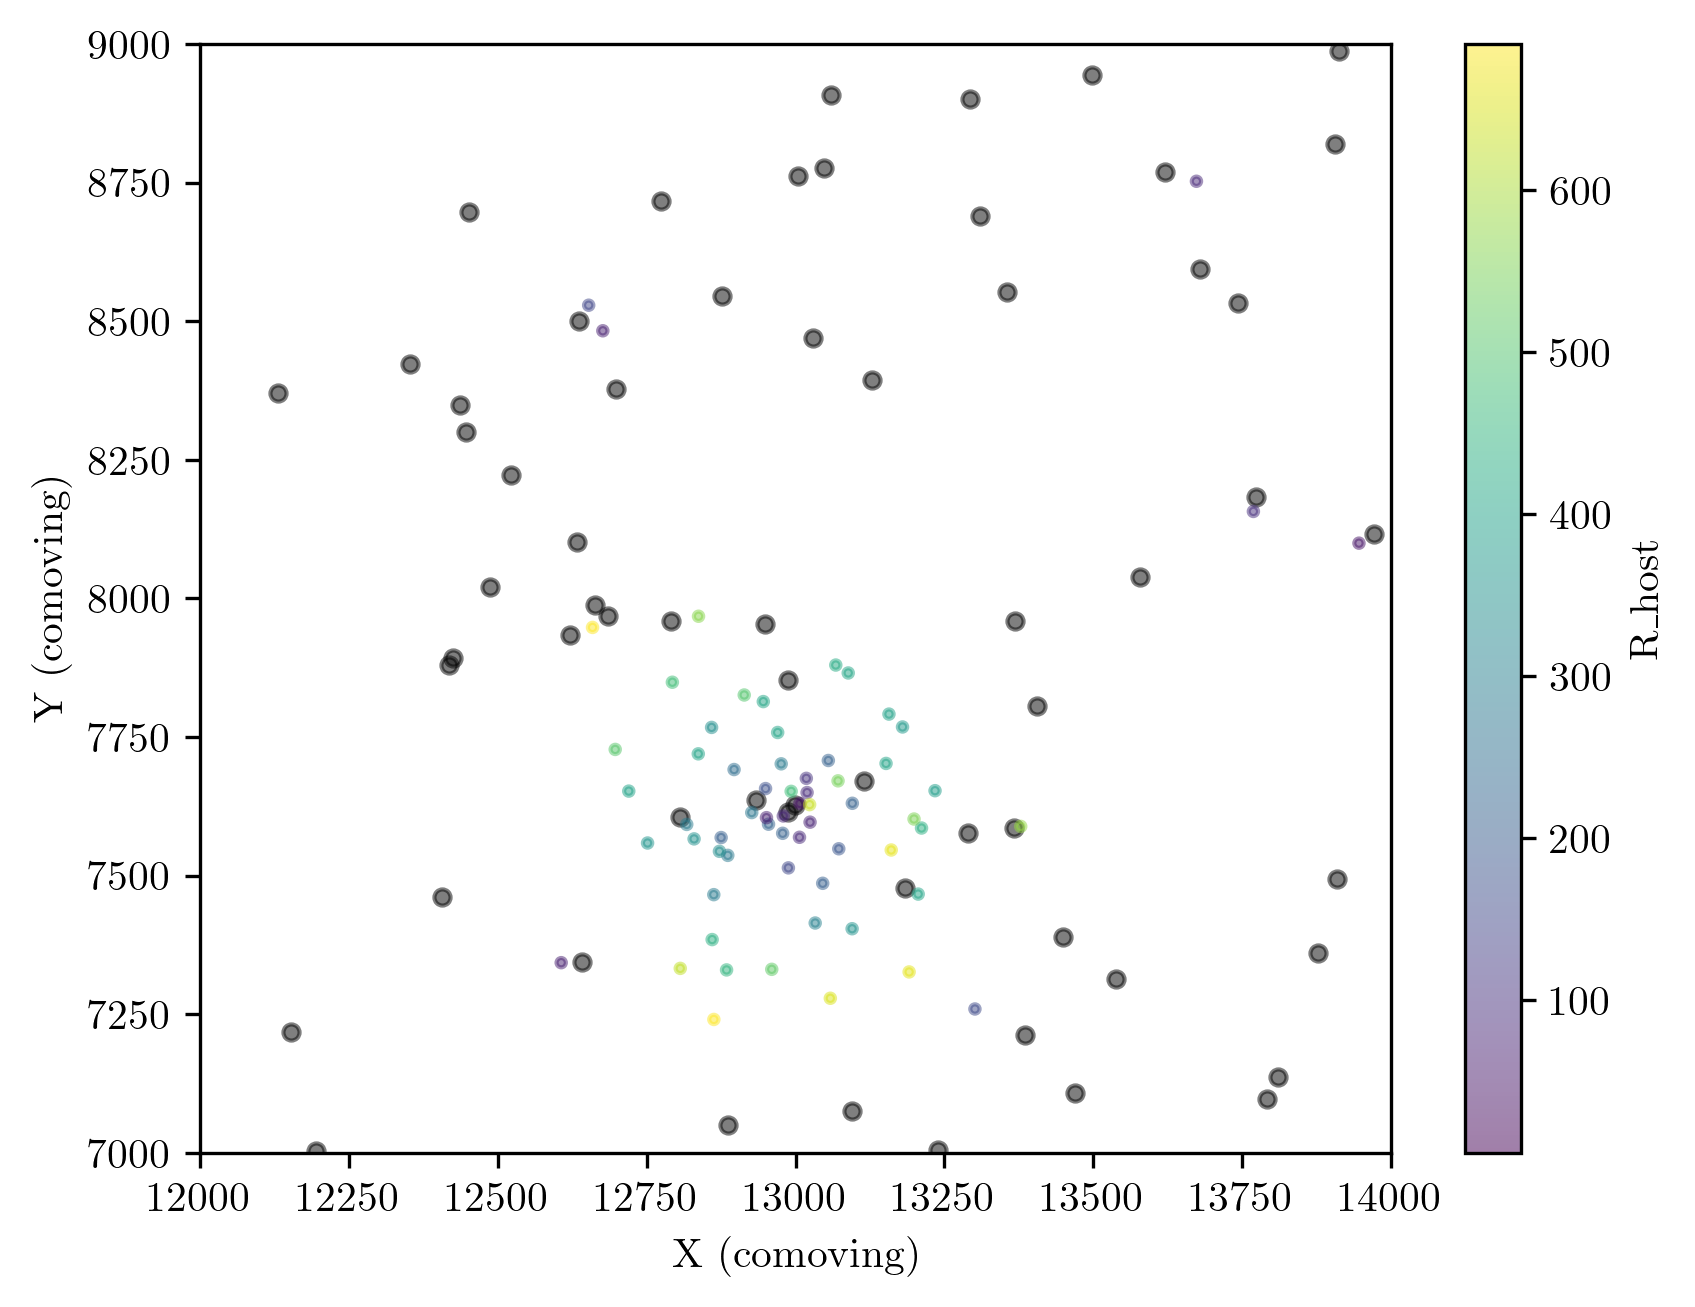

In [11]:
%matplotlib inline
fig, ax = plt.subplots()

x, y, z = 'Xc_ahf_cat', 'Yc_ahf_cat', 'Zc_ahf_cat'

ax.scatter(dat.loc[h_filt, y], dat.loc[h_filt, z],  alpha=0.5, s=15, color='black')

colors = dat.loc[s_filt, 'prox_to_host']
_mappable = ax.scatter(dat.loc[s_filt, y], dat.loc[s_filt, z],  alpha=0.5, s=5, c=colors)
fig.colorbar(_mappable, label='R_{host}')
ax.set_xlim((12000, 14000))
ax.set_ylim((7000, 9000))
ax.set_xlabel('X (comoving)')
ax.set_ylabel('Y (comoving)')
fig.savefig('out.png')

# crs = mplcursors.cursor(ax)

# crs.connect("add", lambda sel: sel.annotation.set_text(
#     'Point {},{}'.format(sel.target[0], sel.target[1])))


In [12]:
max(dat['Xc_ahf_cat'])


14998.68392944

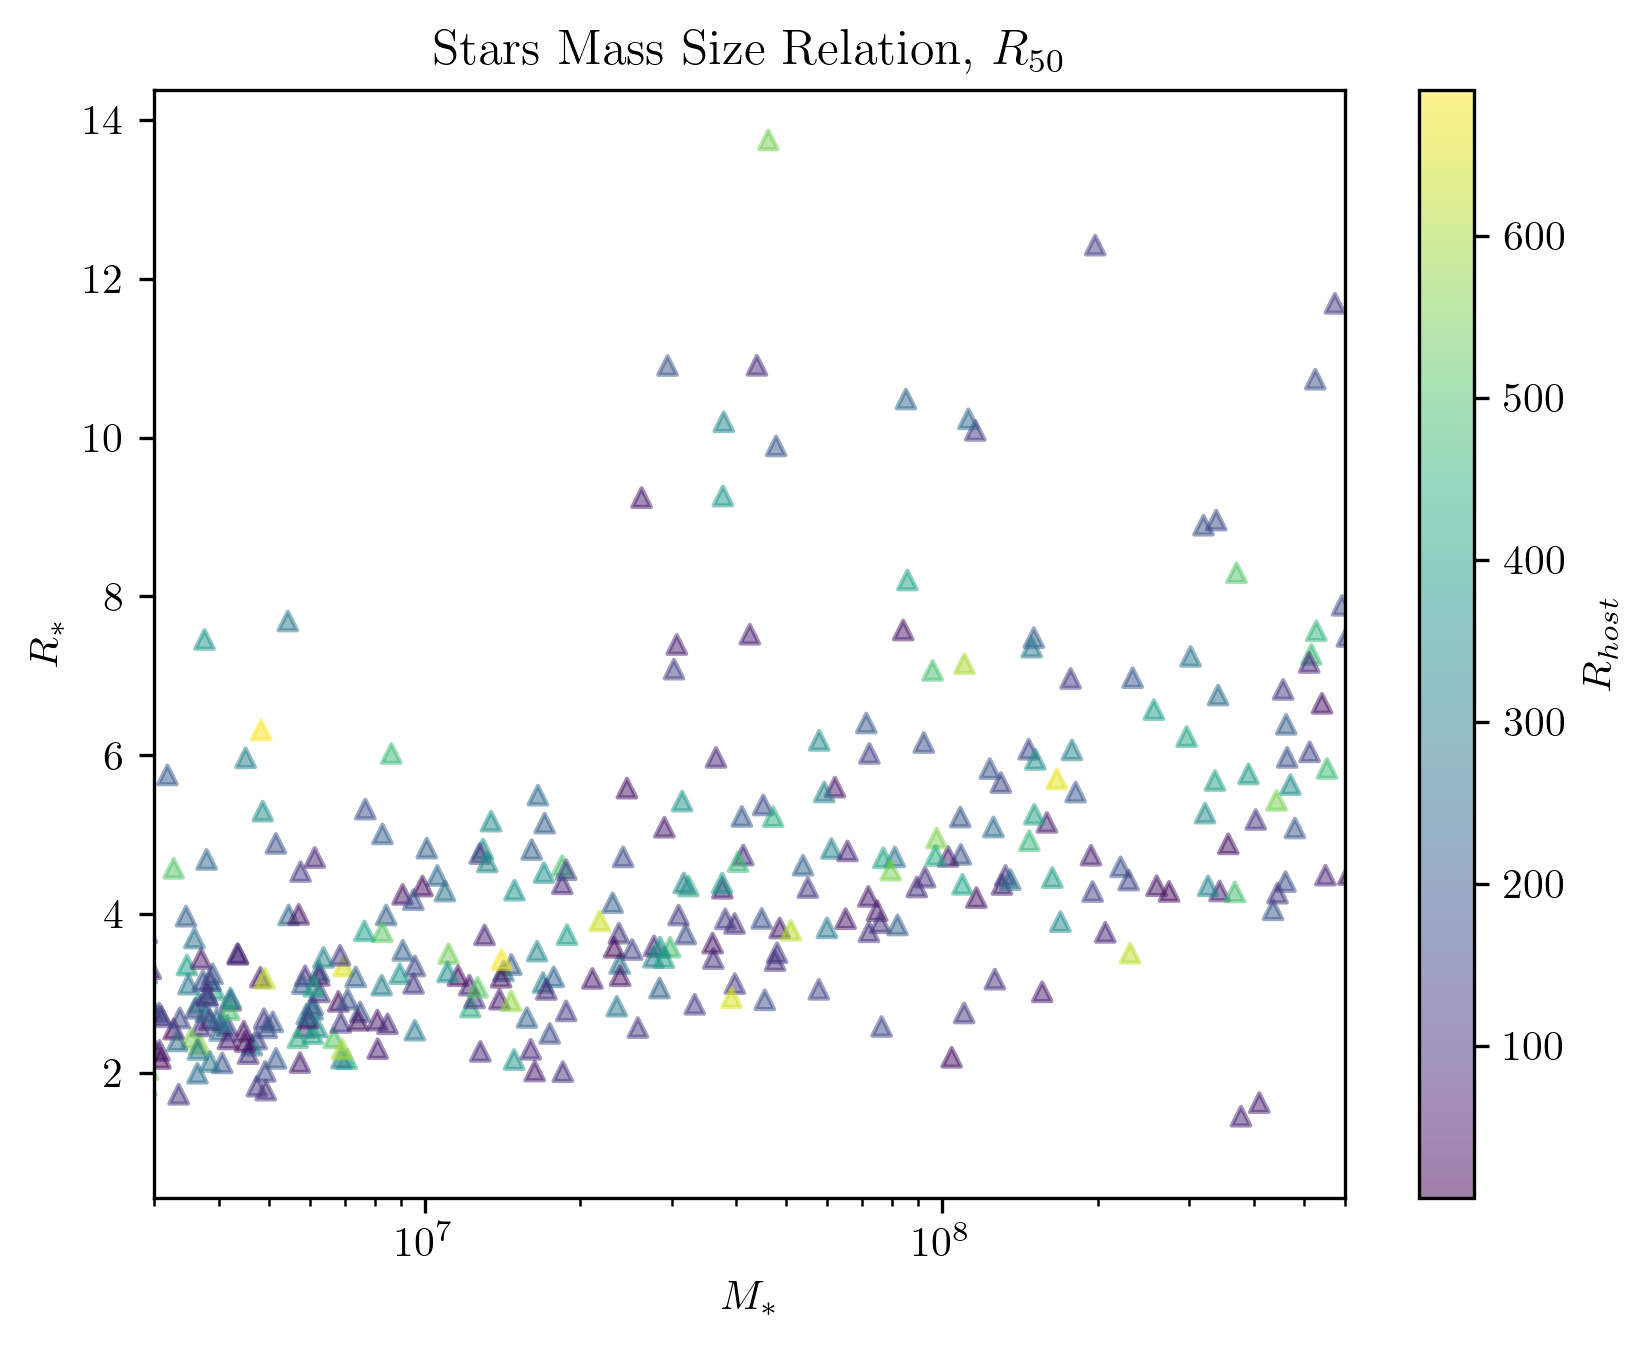

In [13]:
fig = plt.figure()
ax = plt.axes()

ax.set_xscale('log')
# ax.set_yscale('log')

x, y = 'stars_mass_within_r50_stars_ahf', 'r50_stars_ahf'

#ax.scatter(hosts(x), hosts(y), alpha=0.5, s=10, marker='o', color='black')

colors = dat.loc[s_filt, 'prox_to_host']
_mappable = ax.scatter(
    dat.loc[s_filt, x],
    dat.loc[s_filt, y],
    alpha=0.5, s=20, marker='^', c=colors
)
cbar = fig.colorbar(_mappable, label=r'$R_{host}$')
ax.set_xlim(3e6, 6e8)
#ax.set_ylim(1e6, 6e9)

#ax.legend(( 'Hosts', 'Satellites'))
ax.set_title(r'Stars Mass Size Relation, $R_{50}$')
ax.set_xlabel(r'$M_{*}$')
ax.set_ylabel(r'$R_{*}$')
fig.savefig('out.png')


In [14]:
[x for x in dat.columns if 'Rvir' in x]

['Rvir', 'Rvir_ahf', 'Rvir_ahf_cat']

In [15]:
dat['prox_to_host']

0              NaN
1              NaN
2              NaN
3              NaN
4              NaN
           ...    
1715    690.294219
1716    208.481602
1717    226.567167
1718    194.236672
1719     56.131743
Name: prox_to_host, Length: 1720, dtype: float64

(PearsonRResult(statistic=0.21893020325040563, pvalue=2.188409539630992e-06),
 PearsonRResult(statistic=0.2555322617811987, pvalue=2.8224514239256265e-08))

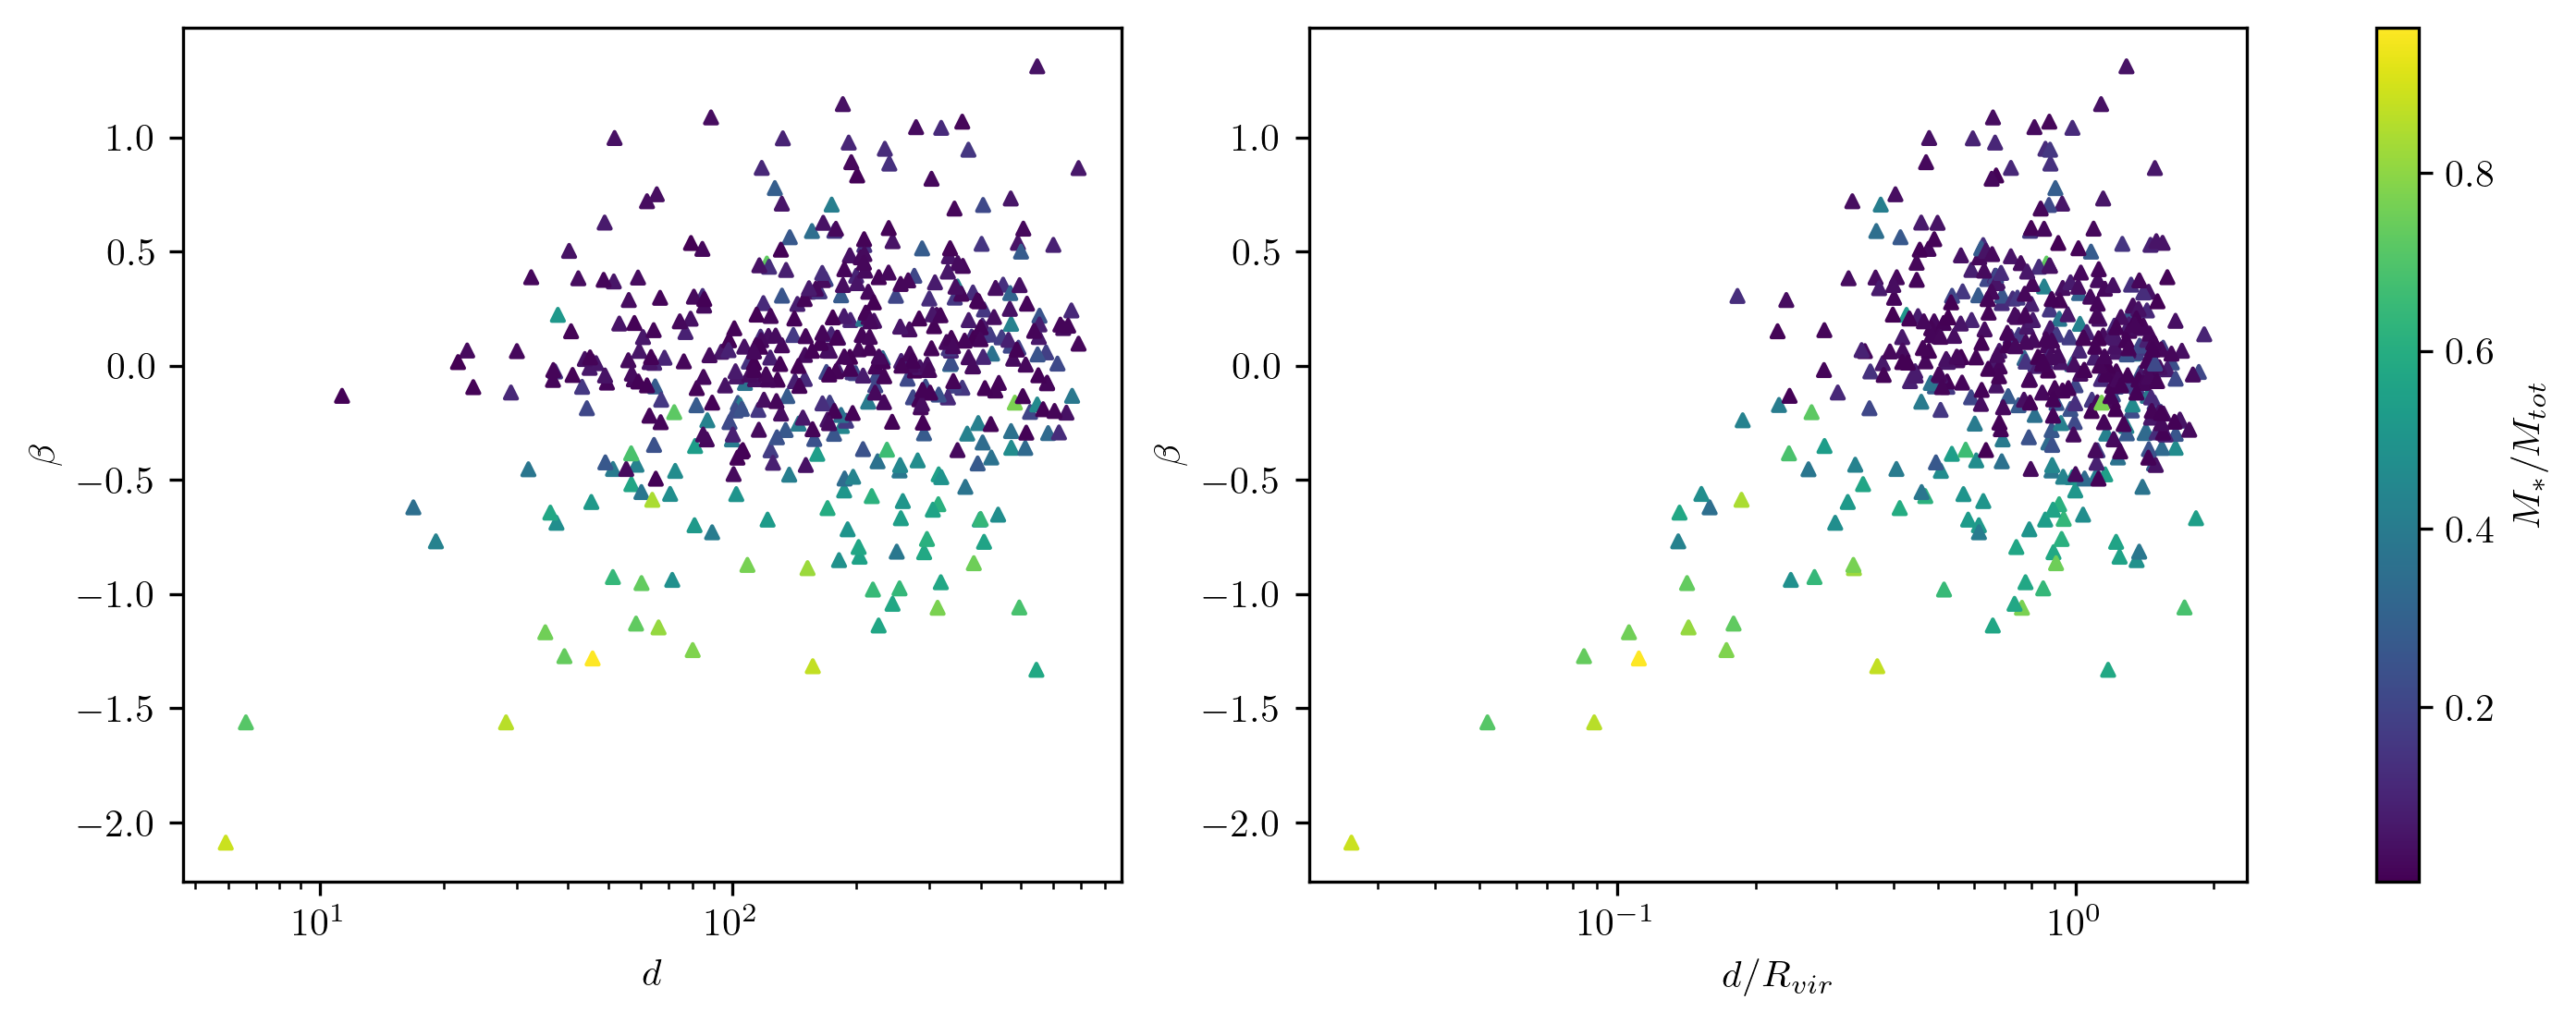

In [32]:
fig, (ax1, ax2) = plt.subplots(1, 2)

ax1.set_xscale('log')
ax2.set_xscale('log')

fig.set_figwidth(12)
fig.set_figheight(4)



_s = ax1.scatter(
    dat[s_filt]['prox_to_host'],
    dat[s_filt]['beta_r50'],
    s=10,
    marker='^',
    c=dat.loc[s_filt, 'M_*/M_tot']
)

ax1.set_xlabel(r'$d$')
ax1.set_ylabel(r'$\beta$')

ax2.scatter(
    dat[s_filt]['prox_to_host'] / dat[s_filt]['host_rvir_cat'],
    dat[s_filt]['beta_r50'],
    s=10,
    marker='^',
    c=dat.loc[s_filt, 'M_*/M_tot']
)

ax2.set_xlabel(r'$d / R_{vir}$')
ax2.set_ylabel(r'$\beta$')


fig.colorbar(_s, ax=[ax1, ax2]).set_label(r'$M_*/M_{tot}$')

fig.savefig('paper/figs/me/beta-d.pdf')

(
    pearsonr(
        np.log(dat[s_filt]['prox_to_host']),
        dat[s_filt]['beta_r50']
    ),
    pearsonr(
        np.log(dat[s_filt]['prox_to_host'] / dat[s_filt]['host_rvir_cat']),
        dat[s_filt]['beta_r50']
    )
)

In [19]:
filt = s_filt & (dat['prox_to_host'] / dat['host_rvir_cat'] > 0.2)

(
    pearsonr(
        np.log(dat[filt]['prox_to_host']),
        dat[filt]['beta_r50']
    ),
    pearsonr(
        np.log(dat[filt]['prox_to_host'] / dat[filt]['host_rvir_cat']),
        dat[filt]['beta_r50']
    )
)

(PearsonRResult(statistic=0.056527659330929445, pvalue=0.23561867997928823),
 PearsonRResult(statistic=-0.031332060873267134, pvalue=0.5111713616634908))

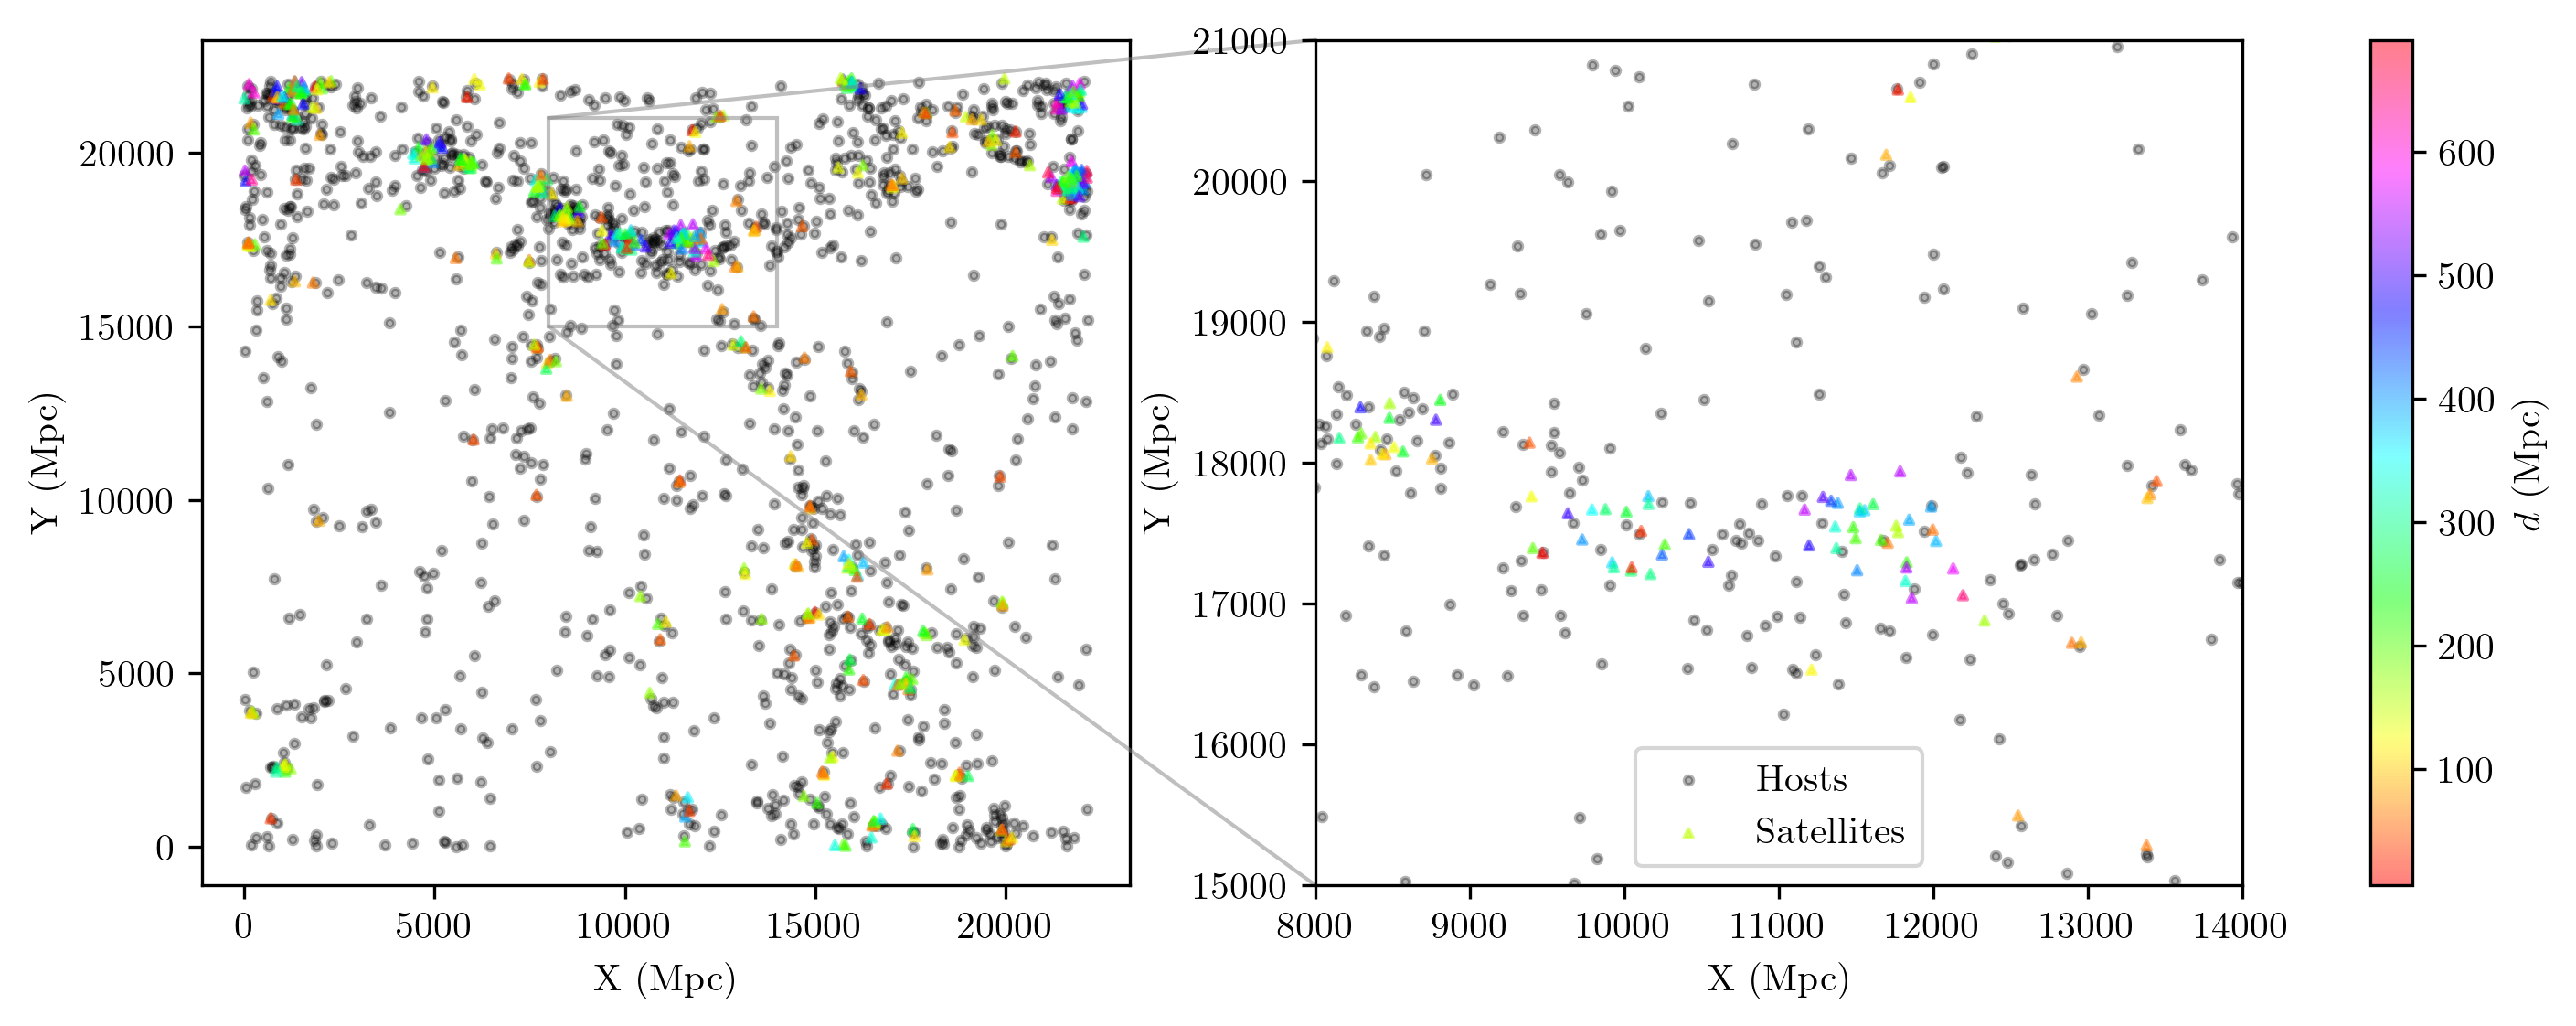

In [46]:
%matplotlib inline
fig, (ax1, ax2) = plt.subplots(1, 2)
fig.set_figwidth(12)
fig.set_figheight(4)

x, y, z = 'X_Mpc_ahf_cat', 'Y_Mpc_ahf_cat', 'Z_Mpc_ahf_cat'

_size = 5

for ax in ax1, ax2:
    ax.scatter(
        dat.loc[h_filt, x],
        dat.loc[h_filt, y],
        alpha=0.3,
        s=_size,
        color='black')

    sctr = ax.scatter(
        dat.loc[s_filt, x],
        dat.loc[s_filt, y], 
        alpha=0.5,
        s=_size,
        c=dat.loc[s_filt, 'prox_to_host'],
        cmap=CMAP,
        marker='^'
    )
    ax.set_xlabel(f'{x[0].upper()} (Mpc)')
    ax.set_ylabel(f'{y[0].upper()} (Mpc)')

square_loc = 8000, 15000
square_size = 6000

square_x = square_loc[0], square_loc[0] + square_size
square_y = square_loc[1], square_loc[1] + square_size

ax2.set_xlim(square_x)
ax2.set_ylim(square_y)

ax1.indicate_inset_zoom(ax2)


fig.colorbar(sctr, ax=[ax1, ax2], label=r'$d$ (Mpc)')
# ax.set_xlim((0 / h, 15000 / h))
# ax.set_ylim((0 / h, 10000 / h))


ax.legend(('Hosts', 'Satellites'))

fig.savefig('paper/figs/me/locations.pdf')



In [49]:
(15 / h)

22.143489813994684